# Time-varying Regression Coefficient via Gaussian Random Walk in Pymc

Before reading this notebook it is worth going throught the notebook **Exploring tools for interpretable machine learning**


### References 
**Notebook** - [Time-Varying Regression Coefficients via Gaussian Random Walk in PyMC](https://juanitorduz.github.io/bikes_pymc/)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed: int = sum(map(ord, "bikes"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(
    data_path,
    dtype={
        "season": "category",
        "mnth": "category",
        "holiday": "category",
        "weekday": "category",
        "workingday": "category",
        "weathersit": "category",
        "cnt": "int",
    },
)

raw_data_df.head()

season    yr mnth     holiday weekday      workingday weathersit      temp  \
0  WINTER  2011  JAN  NO HOLIDAY     SAT  NO WORKING DAY      MISTY  8.175849   
1  WINTER  2011  JAN  NO HOLIDAY     SUN  NO WORKING DAY      MISTY  9.083466   
2  WINTER  2011  JAN  NO HOLIDAY     MON     WORKING DAY       GOOD  1.229108   
3  WINTER  2011  JAN  NO HOLIDAY     TUE     WORKING DAY       GOOD  1.400000   
4  WINTER  2011  JAN  NO HOLIDAY     WED     WORKING DAY       GOOD  2.666979   

       hum  windspeed   cnt  days_since_2011  
0  80.5833  10.749882   985                0  
1  69.6087  16.652113   801                1  
2  43.7273  16.636703  1349                2  
3  59.0435  10.739832  1562                3  
4  43.6957  12.522300  1600                4

In [4]:
# Data formatting

data_df = raw_data_df.copy()

data_df["date"] = pd.to_datetime("2011-01-01") + data_df["days_since_2011"].apply(
    lambda z: pd.Timedelta(z, unit="D")
)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    category      
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    category      
 3   holiday          731 non-null    category      
 4   weekday          731 non-null    category      
 5   workingday       731 non-null    category      
 6   weathersit       731 non-null    category      
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: category(6), datetime64[ns](1), float64(3), int64(3)
memory usage: 45.6 KB


In [5]:
# get min and max date in the dataframe
print(data_df["date"].min())
print(data_df["date"].max())


2011-01-01 00:00:00
2012-12-31 00:00:00


[Text(0.5, 1.0, 'Temperature')]

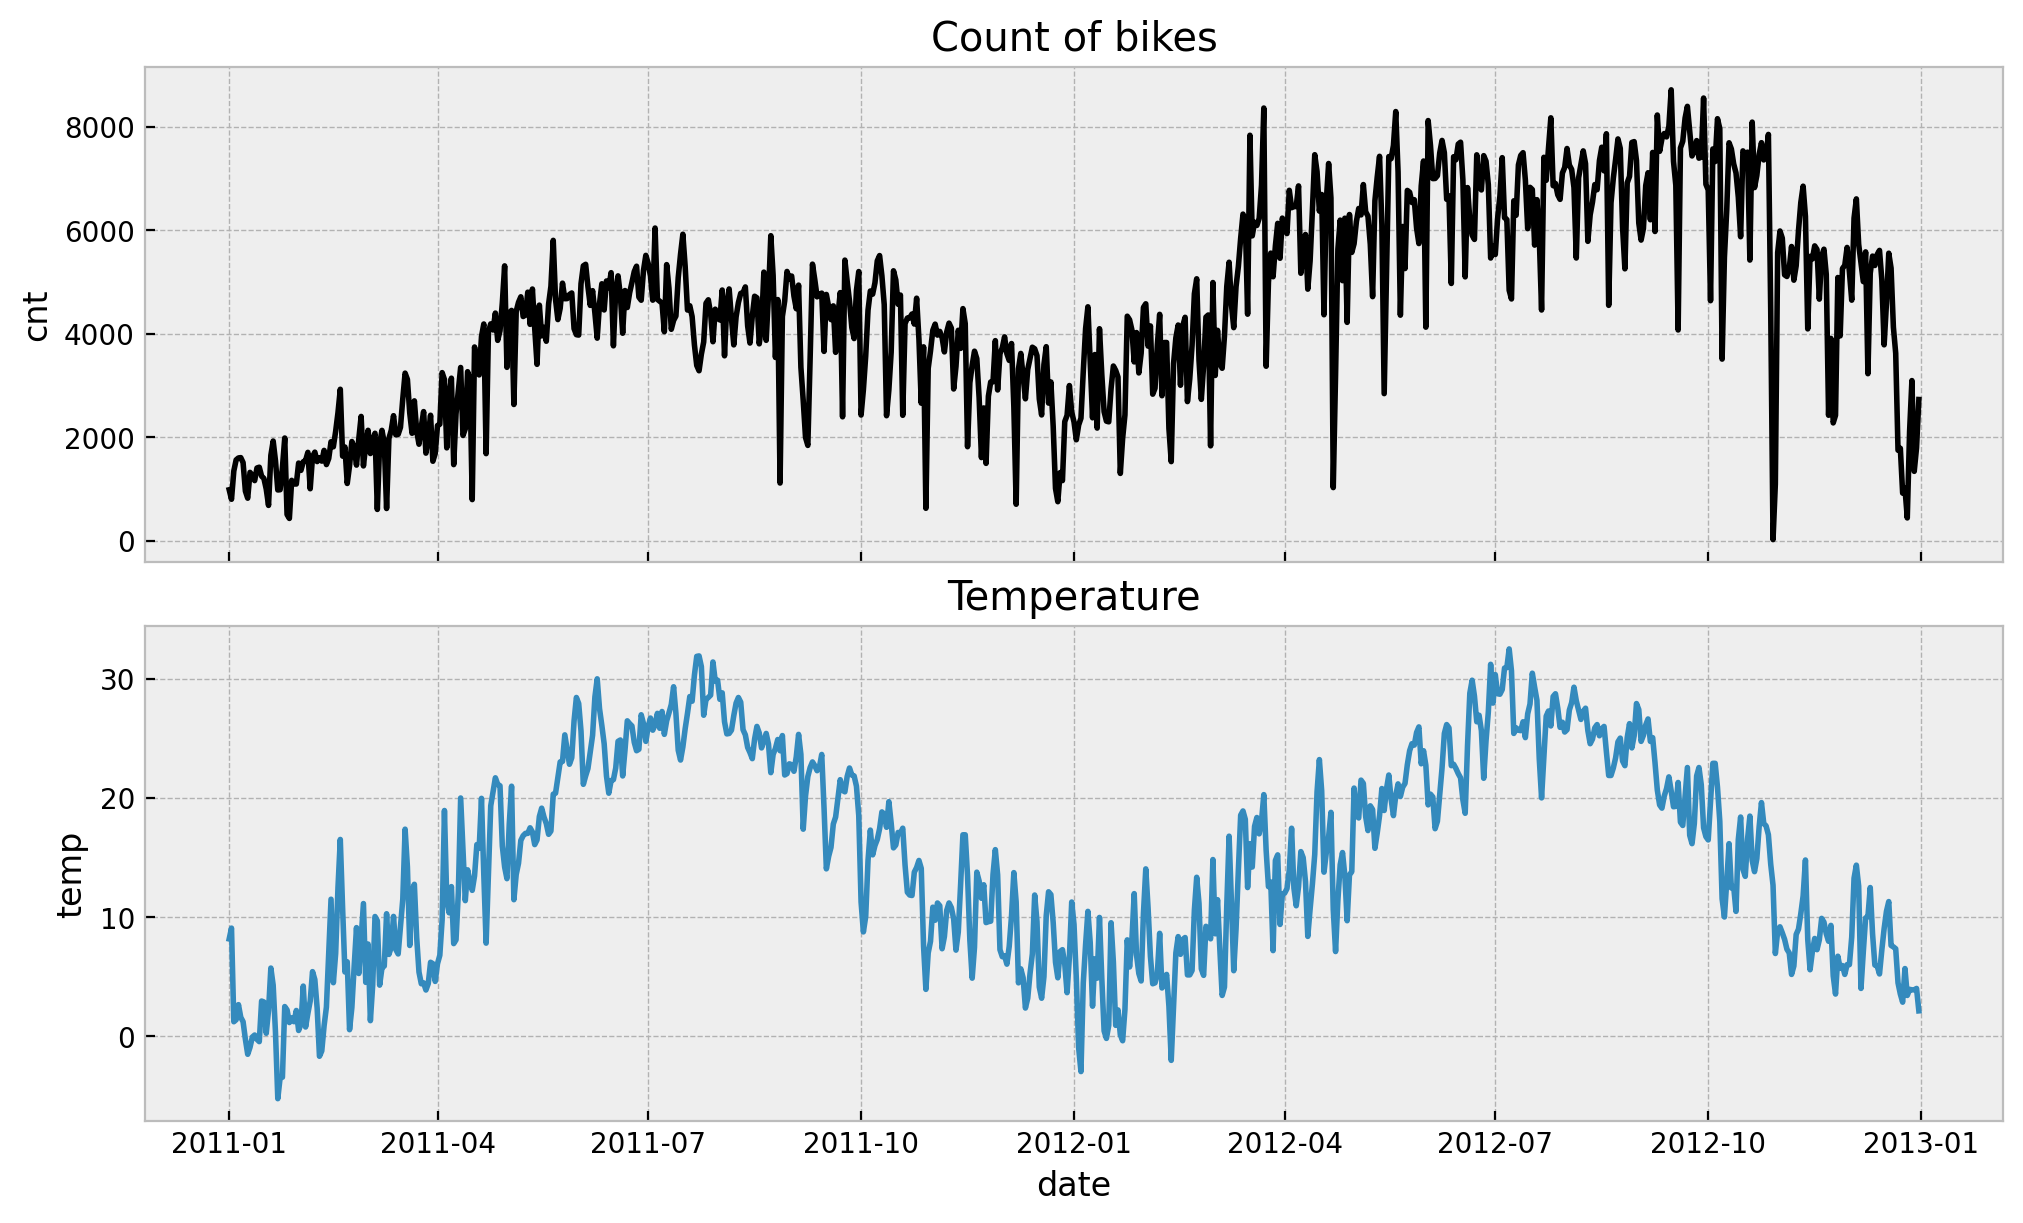

In [6]:
# Time development of the bike rentals and temperature over time.

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 6),
    sharex=True,
    sharey=False,
    layout="constrained"
)

sns.lineplot(x="date", y="cnt", data=data_df, color="black", ax=ax[0]) # CNT stands for count of bikes.
sns.lineplot(x="date", y="temp", data=data_df, color="C0", ax=ax[1])
ax[0].set(title="Count of bikes")
ax[1].set(title="Temperature")

[Text(0.5, 1.0, 'End-of-Year Gaussian Bump')]

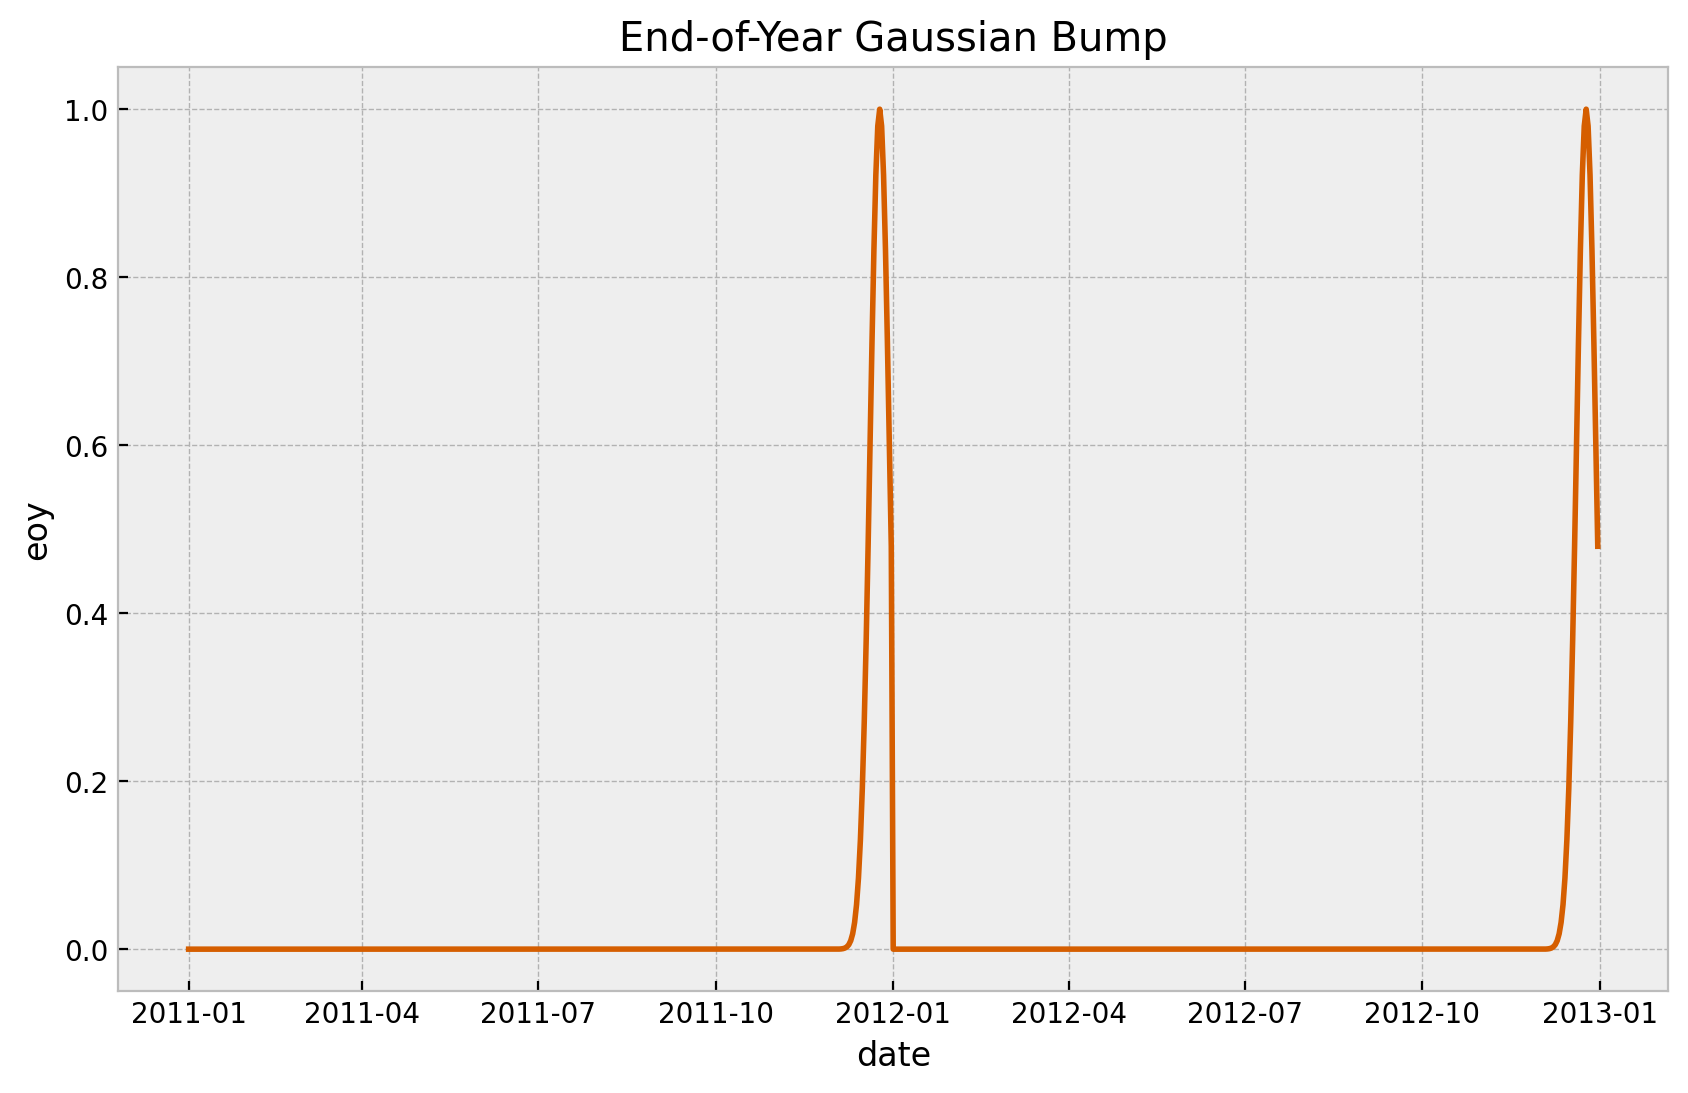

In [7]:
# Add gaussian bump function to model the end of year seasonality.

is_december = data_df["date"].dt.month == 12
eoy_mu = 25
eoy_sigma = 7
eoy_arg = (data_df["date"].dt.day - eoy_mu) / eoy_sigma
data_df["eoy"] = is_december * np.exp(-(eoy_arg**2))

fig, ax = plt.subplots()
sns.lineplot(x="date", y="eoy", data=data_df, color="C4", ax=ax)
ax.set(title="End-of-Year Gaussian Bump")

In [8]:
# Before fitting a linear model it is always good to scale the data.

target = "cnt"
target_scaled = f"{target}_scaled"

endog_scaler = MinMaxScaler() # used to scale the target variable.
exog_scaler = MinMaxScaler() # used to scale the predictor variables.


data_df[target_scaled] = endog_scaler.fit_transform(X=data_df[[target]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)

Before going to the Feature selection let's explain how the factorize function works in pandas.

Factorize is used to convert a categorical variable into a numerical representation. The method returns two outputs:
1. A numerical array that represents the labels (or factors) of the categorical variable.
2. An index (or optionally an array) that represents the unique values of the categorical variable in the order they were factorized.

Example :
```
import pandas as pd

s = pd.Series(['cat', 'dog', 'dog', 'cat', 'bird'])
labels, unique = s.factorize()

print(labels)  # array([0, 1, 1, 0, 2])
print(unique)  # Index(['cat', 'dog', 'bird'], dtype='object')
```

In [9]:
# -----FEATURE SELECTION----

n = data_df.shape[0]

# TARGET
cnt = data_df[target].to_numpy()
cnt_scaled = data_df[target_scaled].to_numpy()

# DATE FEATURE
date = data_df["date"].to_numpy()

# MODEL REGRESSORS
temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)

t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()
eoy = data_df["eoy"].to_numpy()

## Base Model

Base regression model. 


### Bayesian workflow

* **Prior** distributions for the regressin coefficients and the noise.
* **Model parametrazation** i.e. the structure of the linear model. Note that for the categorical variables we use `ZeroSumNormal` since we are adding an intercept term.
* **Likelihood function** which is the case we decide for a StudentT distribution. 

In [10]:
# 1. Model Specification

coords = {
    "date": date,
    "workingday": workingday,
    "weathersit": weathersit,
}

with pm.Model(coords=coords) as base_model:
    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_temp = pm.Normal(name="b_temp", mu=0, sigma=1)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=1)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=1)
    # b_holiday = pm.ZeroSumNormal(name="b_holiday", sigma=1, dims="holiday")
    b_workingday = pm.ZeroSumNormal(name="b_workingday", sigma=1, dims="workingday")
    b_weathersit = pm.ZeroSumNormal(name="b_weathersit", sigma=1, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    b_eoy = pm.Normal(name="b_eoy", mu=0, sigma=1)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=1)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            # + b_holiday[holiday_idx]
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
            + b_eoy * eoy
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )


# pm.model_to_graphviz(base_model)

Sampling: [b_eoy, b_hum, b_t, b_temp, b_weathersit, b_windspeed, b_workingday, intercept, likelihood, nu, sigma]


[Text(0.5, 1.0, 'Base Model - Prior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt_scaled')]

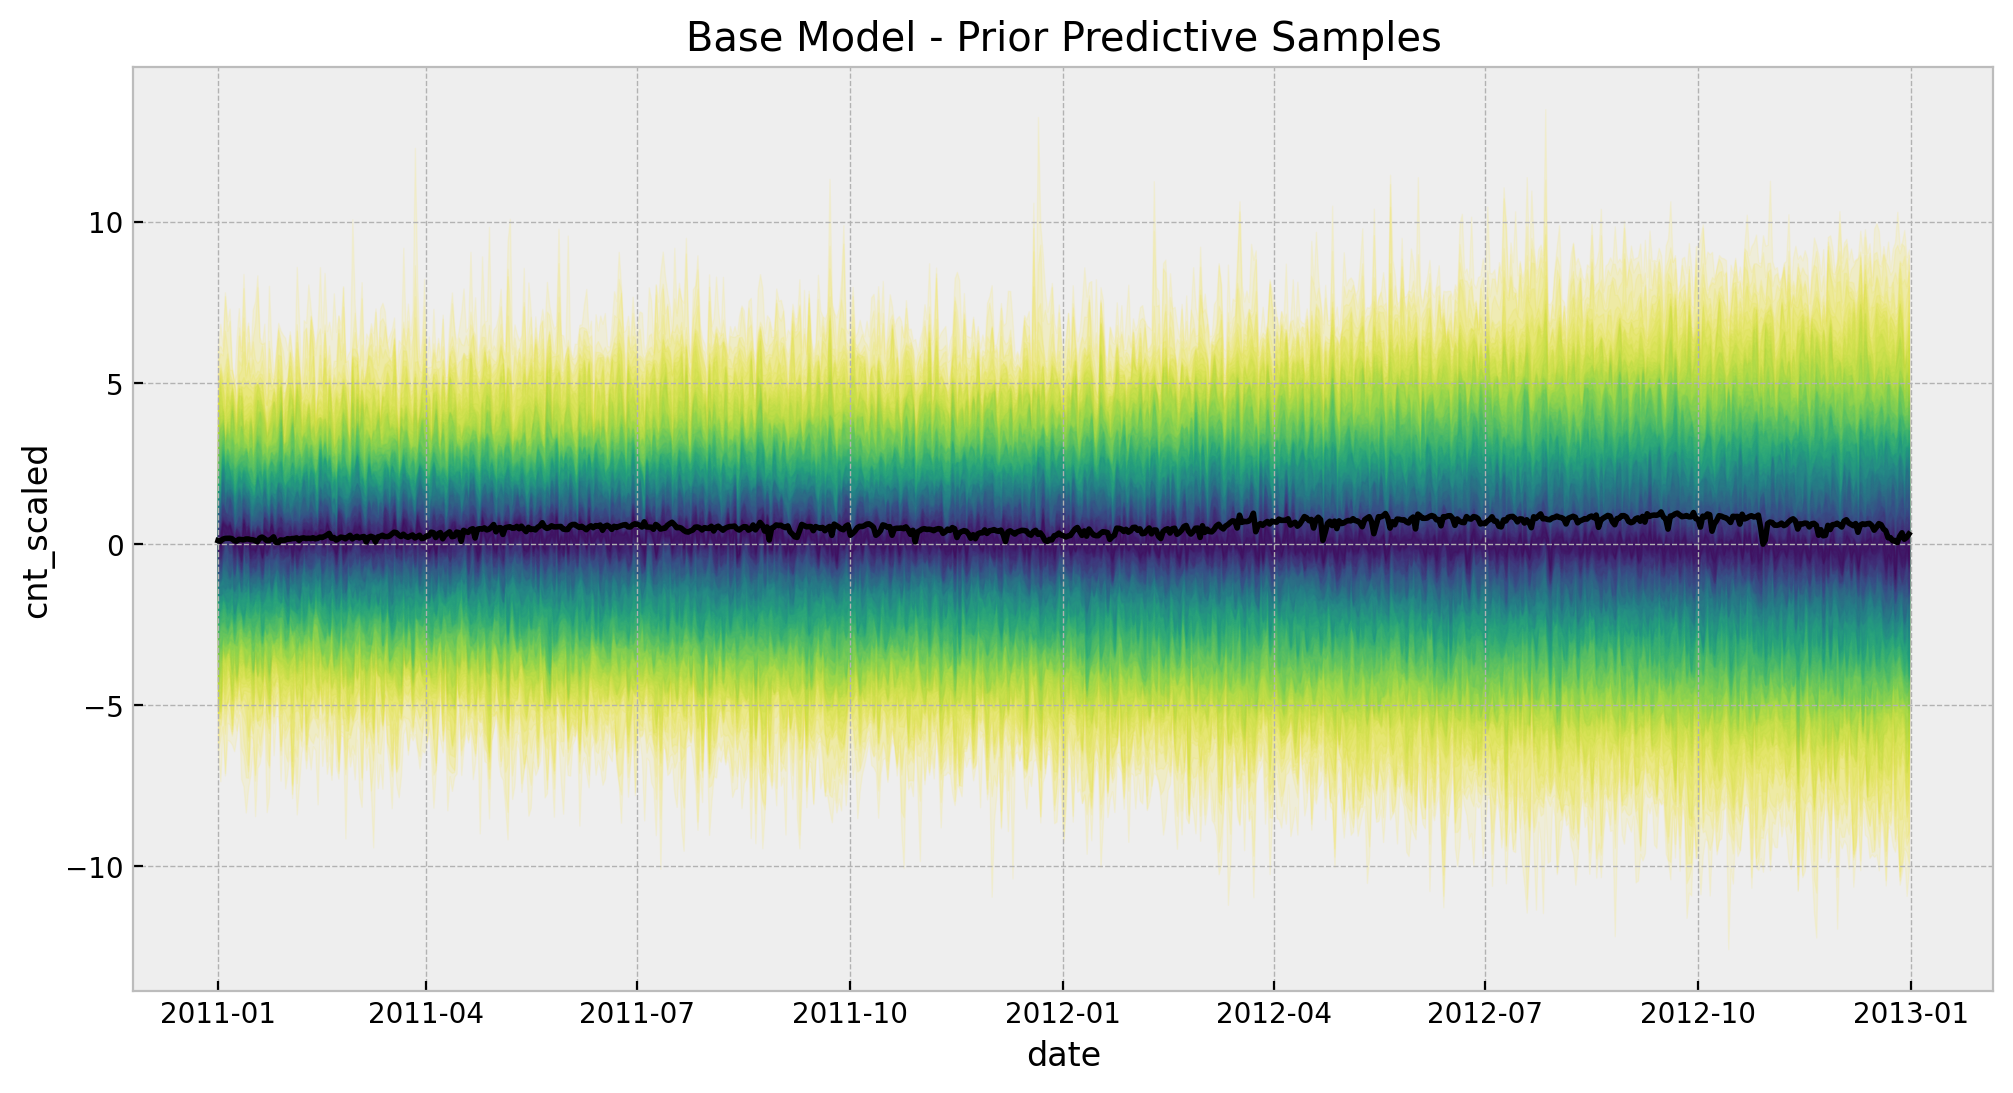

In [11]:
# 2. Prior Predictive Analysis 

with base_model:
    # --- prior samples ---
    prior_predictive_base = pm.sample_prior_predictive(samples=200, random_seed=rng)


palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], p, axis=1
    )
    lower = np.percentile(
        prior_predictive_base.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.set(
    title="Base Model - Prior Predictive Samples",
    xlabel="date",
    ylabel=target_scaled,
)

In [15]:
# Model fit

with base_model:
    idata_base = pm.sample(
        target_accept=0.9,
        draws=2_000,
        chains=5,
        nuts_sampler="numpyro",
        idata_kwargs={"log_likelihood": True},
        random_seed=rng,
    )
    posterior_predictive_base = pm.sample_posterior_predictive(
        trace=idata_base, random_seed=rng
    )

Compiling...
Compilation time =  0:00:03.283469
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

















Running chain 0:   0%|          | 0/3000 [00:02<?, ?it/s]

Running chain 0:   5%|▌         | 150/3000 [00:03<00:03, 837.00it/s]




Running chain 0:  10%|█         | 300/3000 [00:03<00:02, 955.95it/s]



Running chain 0:  15%|█▌        | 450/3000 [00:03<00:02, 1091.36it/s]





Running chain 0:  20%|██        | 600/3000 [00:03<00:02, 1120.49it/s]





Running chain 0:  30%|███       | 900/3000 [00:03<00:01, 1285.91it/s]




Running chain 0:  35%|███▌      | 1050/3000 [00:03<00:01, 1247.78it/s]





Running chain 0:  40%|████      | 1200/3000 [00:04<00:01, 1193.27it/s]





Running chain 0:  45%|████▌     | 1350/3000 [00:04<00:01, 1168.48it/s]




Running chain 0:  50%|█████     | 1500/3000 [00:04<00:01, 1167.51it/s]




Running chain 0:  55%|█████▌    | 1650/3000 [00:04<00:01, 1129.78it/s]





Running chain 0:  60%|██████    | 1800/3000 [00:04<00:01, 1123.47it/s]




Running chain 0:  65%|██████▌   | 1950/3000 [00

Sampling time =  0:00:06.956702
Transforming variables...
Transformation time =  0:00:00.269110
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:00.767817


In [21]:
# get number of divergences
idata_base

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [22]:
# 4. Model Diagnostics

az.summary(data=idata_base, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                      0.121  0.029   0.067    0.174      0.000   
b_temp                         0.473  0.016   0.443    0.505      0.000   
b_hum                         -0.156  0.032  -0.214   -0.095      0.000   
b_windspeed                   -0.132  0.023  -0.175   -0.087      0.000   
b_t                            0.459  0.012   0.436    0.481      0.000   
b_eoy                         -0.312  0.025  -0.357   -0.265      0.000   
b_workingday[NO WORKING DAY]  -0.009  0.004  -0.017   -0.002      0.000   
b_workingday[WORKING DAY]      0.009  0.004   0.002    0.017      0.000   
b_weathersit[GOOD]             0.085  0.009   0.067    0.102      0.000   
b_weathersit[MISTY]            0.044  0.008   0.029    0.059      0.000   
b_weathersit[RAIN/SNOW/STORM] -0.129  0.015  -0.158   -0.100      0.000   
nu                             4.729  0.787   3.310    6.181      0.009   
sigma                          0.077  0.003   0.071    0.084      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                        0.000    4559.0    5607.0    1.0  
b_temp                           0.000    8384.0    7268.0    1.0  
b_hum                            0.000    5401.0    6820.0    1.0  
b_windspeed                      0.000    7312.0    7016.0    1.0  
b_t                              0.000    8898.0    7682.0    1.0  
b_eoy                            0.000    9973.0    7027.0    1.0  
b_workingday[NO WORKING DAY]     0.000   12294.0    7498.0    1.0  
b_workingday[WORKING DAY]        0.000   12294.0    7498.0    1.0  
b_weathersit[GOOD]               0.000    5290.0    6988.0    1.0  
b_weathersit[MISTY]              0.000    7701.0    7274.0    1.0  
b_weathersit[RAIN/SNOW/STORM]    0.000    5516.0    6071.0    1.0  
nu                               0.007    7502.0    7436.0    1.0  
sigma                            0.000    7708.0    7106.0    1.0

Text(0.5, 0.98, 'Base Model - Trace')

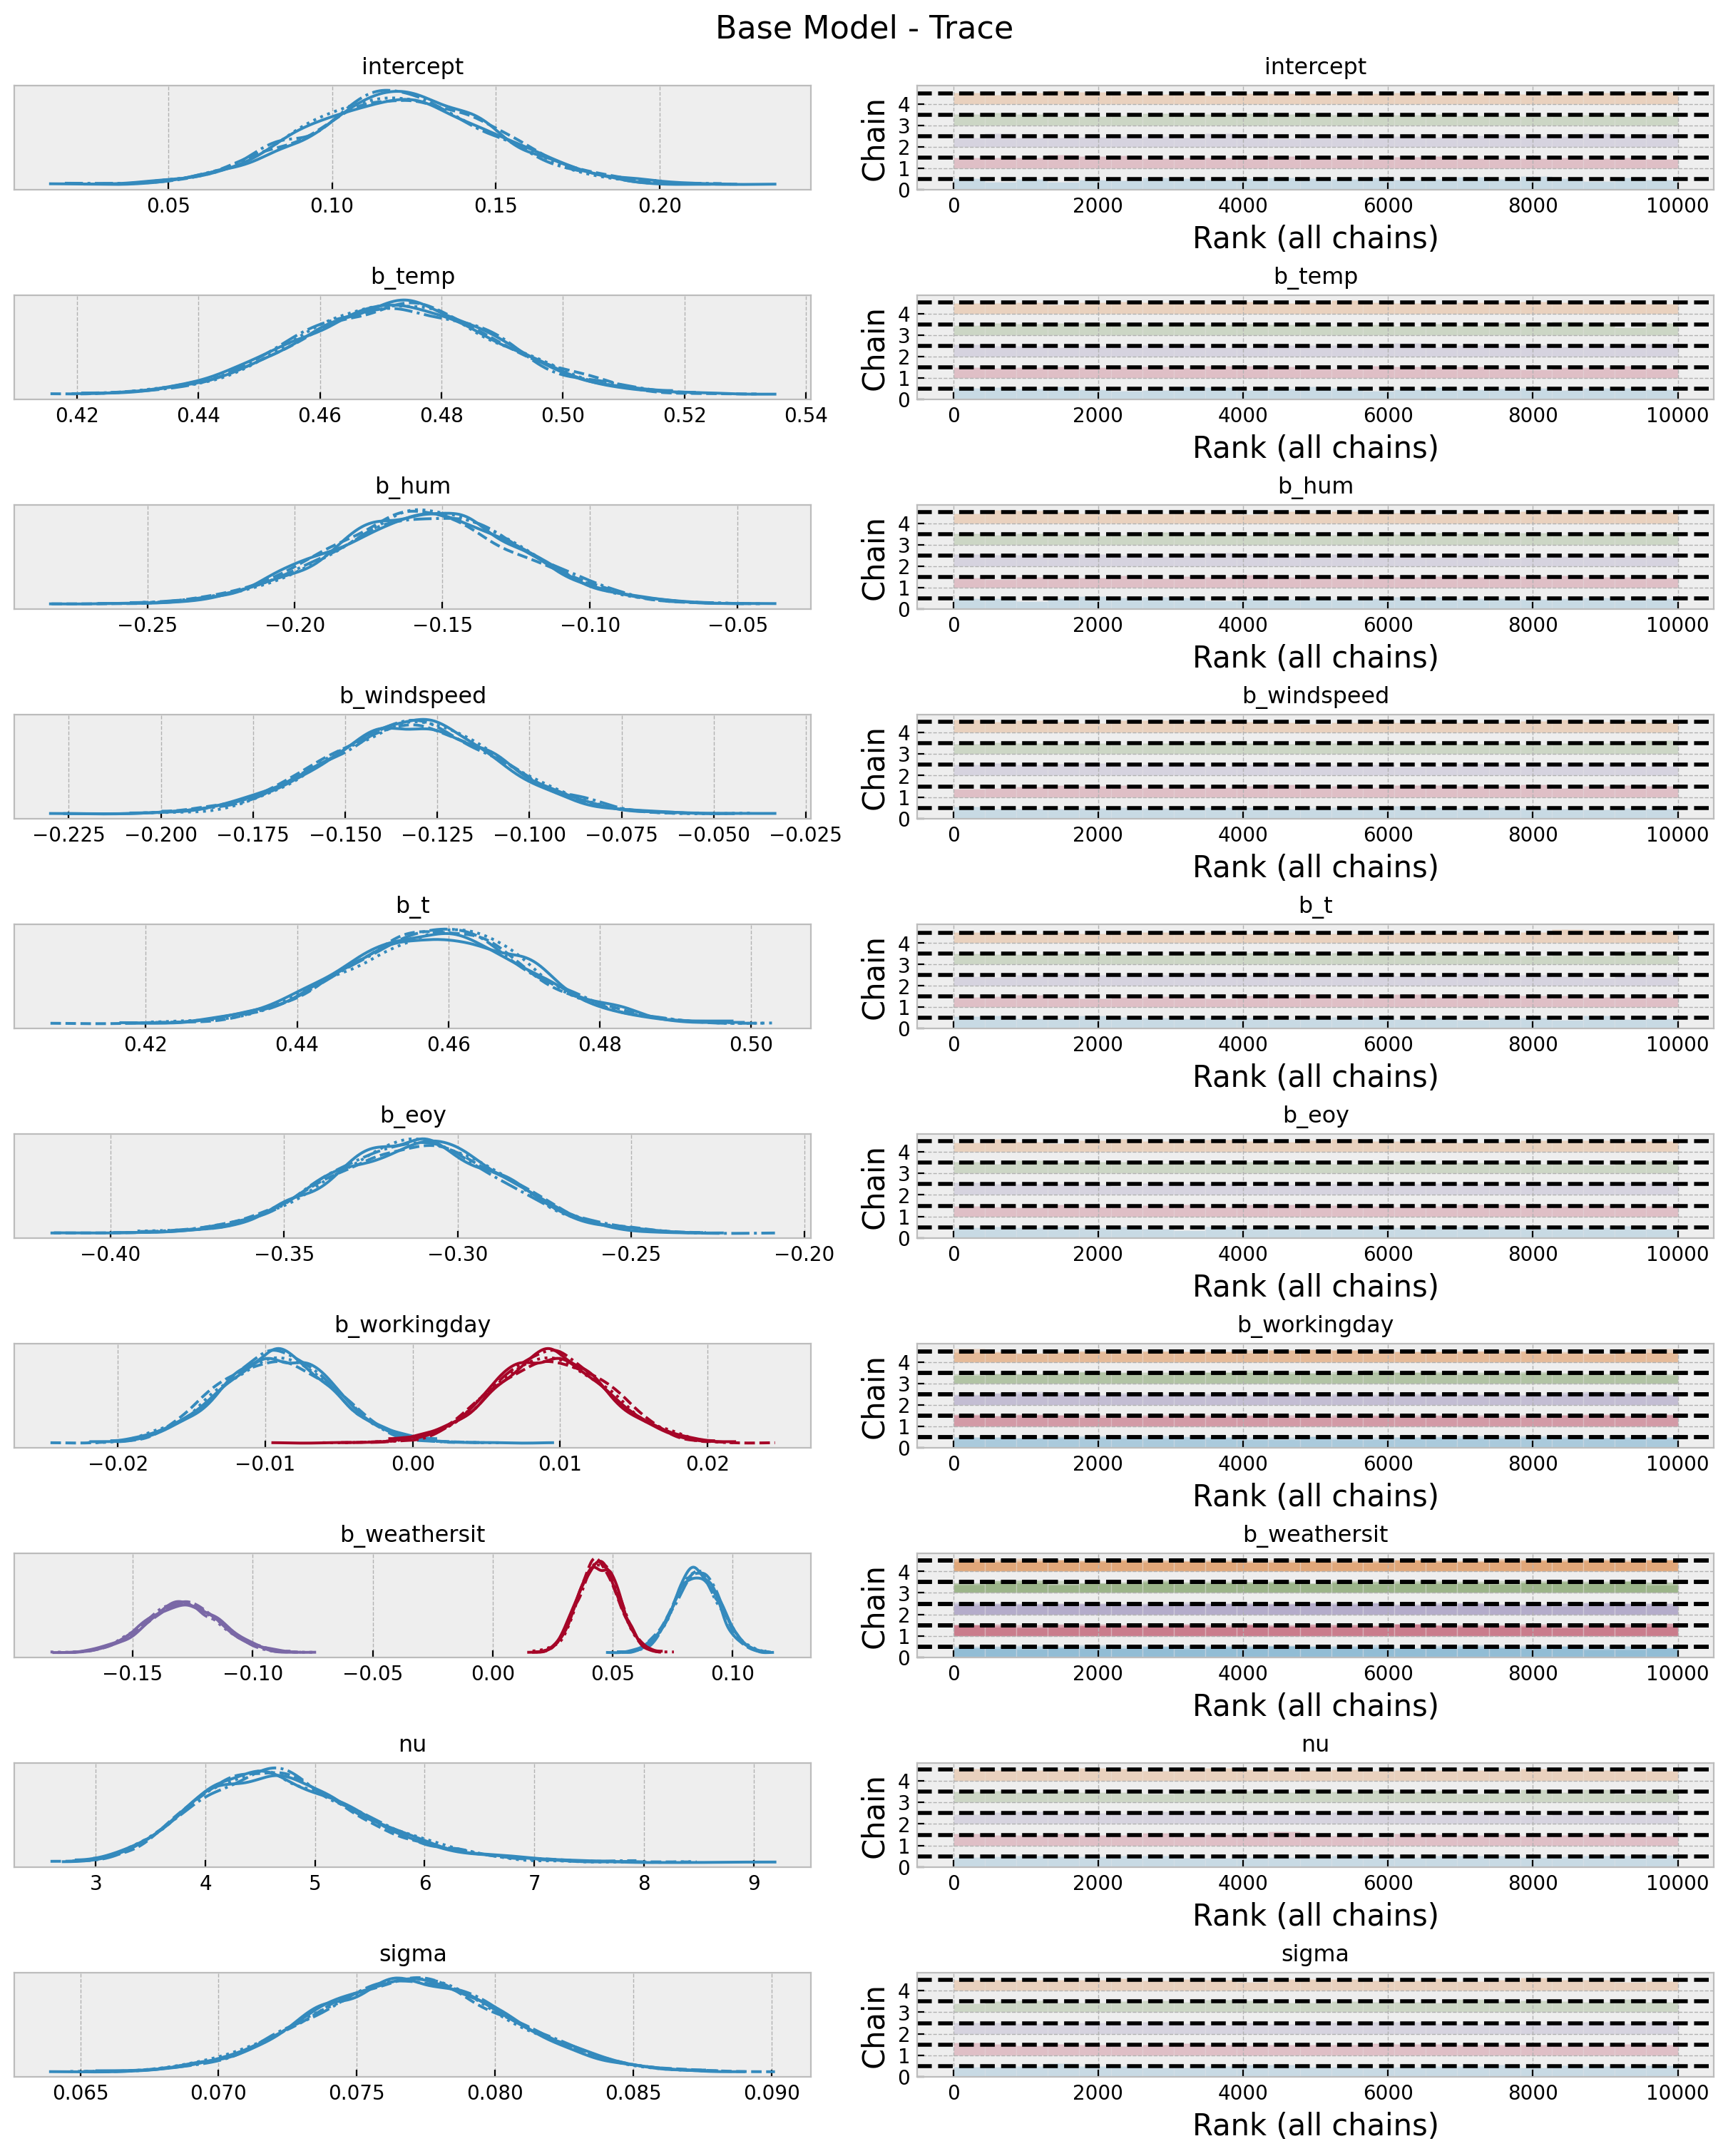

In [23]:
axes = az.plot_trace(
    data=idata_base,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Base Model - Trace", fontsize=16)

Text(0.5, 0.98, 'Base Model - Posterior Distributions')

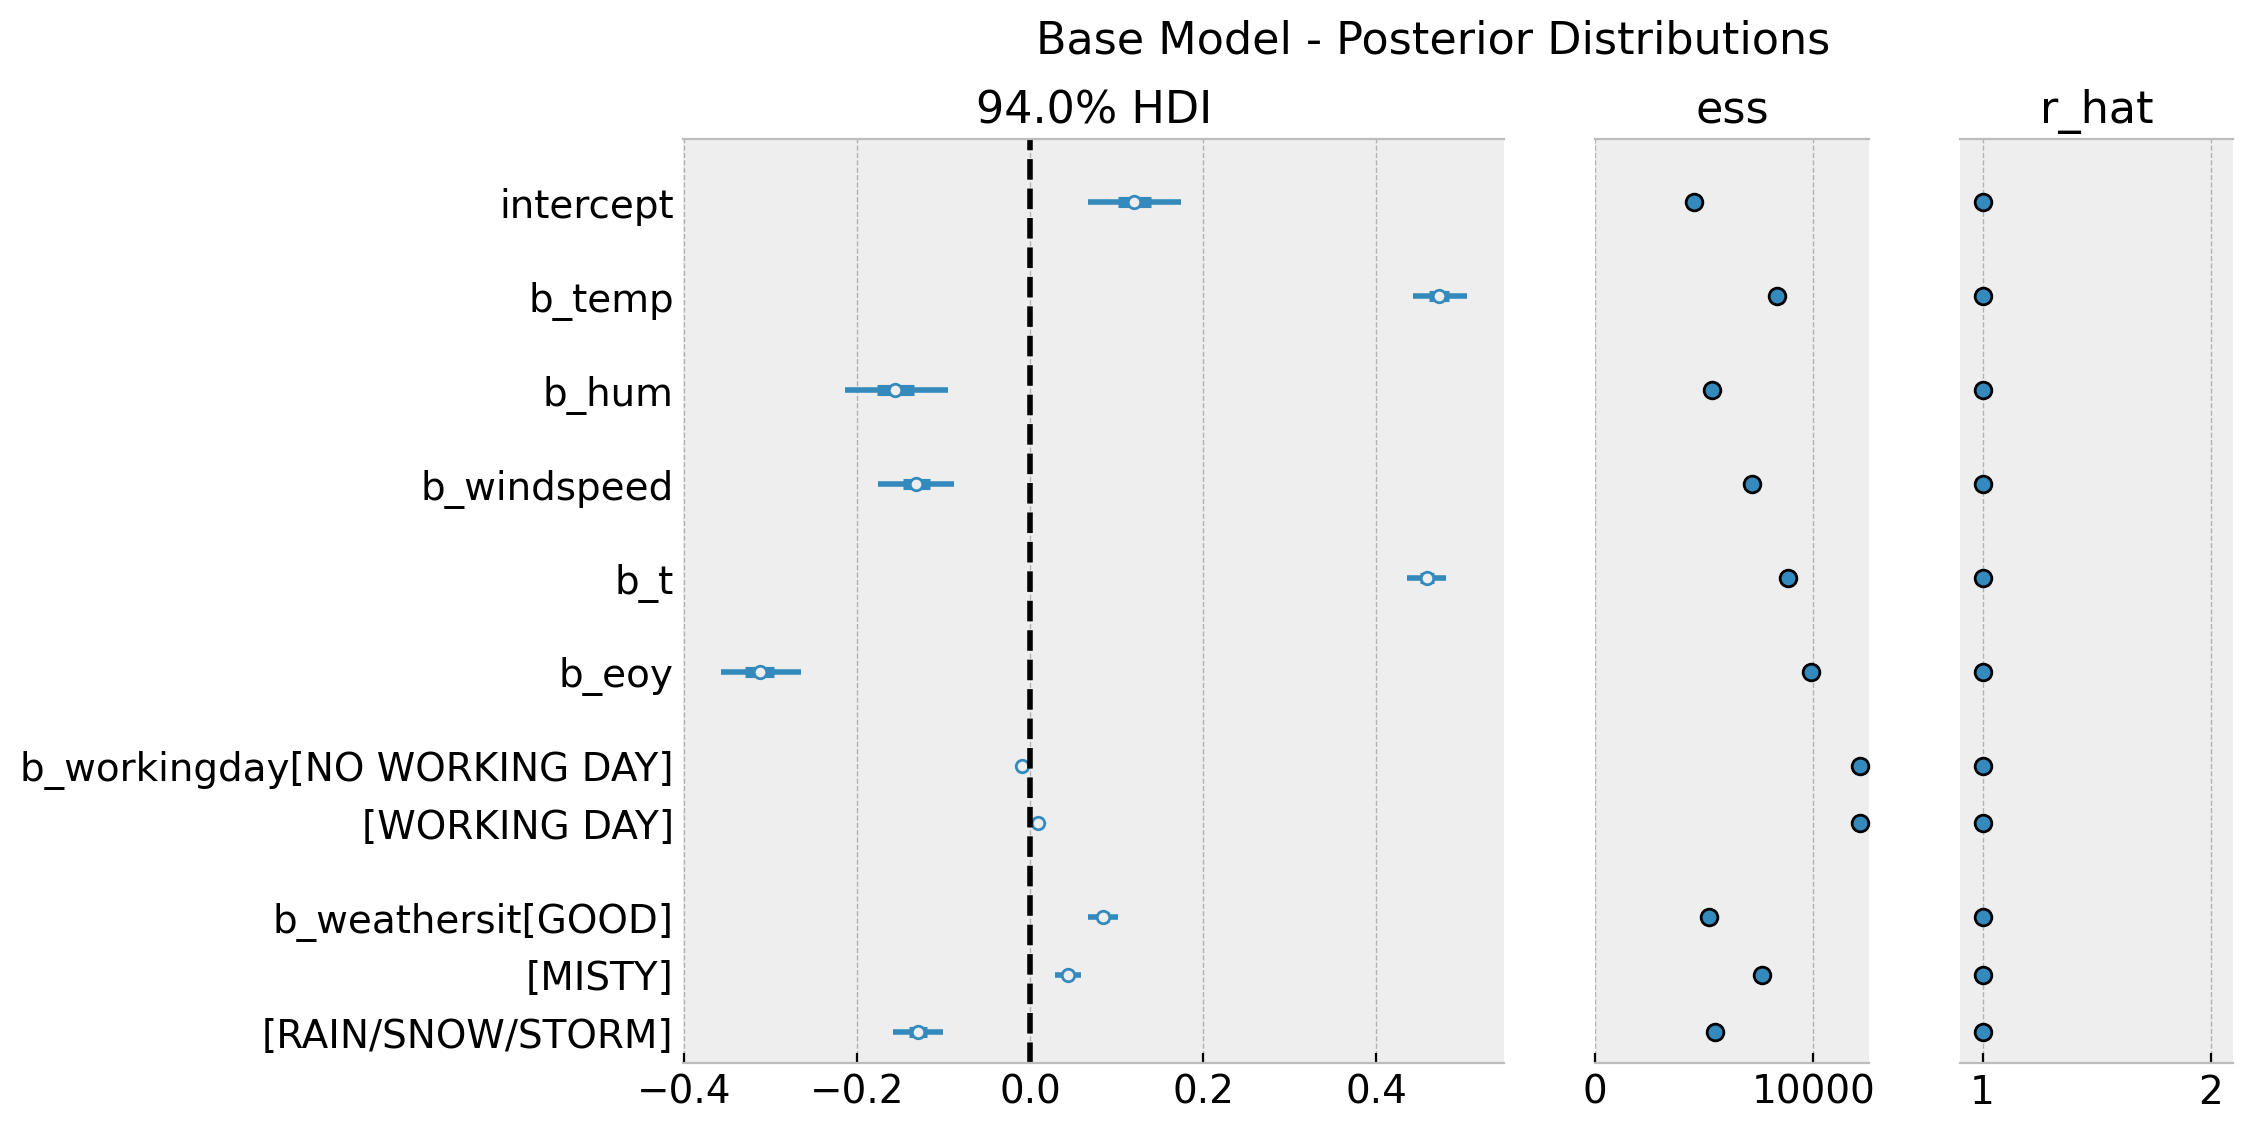

In [24]:
axes = az.plot_forest(
    data=idata_base,
    var_names=["~mu", "~nu", "~sigma"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(10, 6),
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Base Model - Posterior Distributions", fontsize=16)

[Text(0.5, 1.0, 'Base Model - Posterior Predictive Samples'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'cnt')]

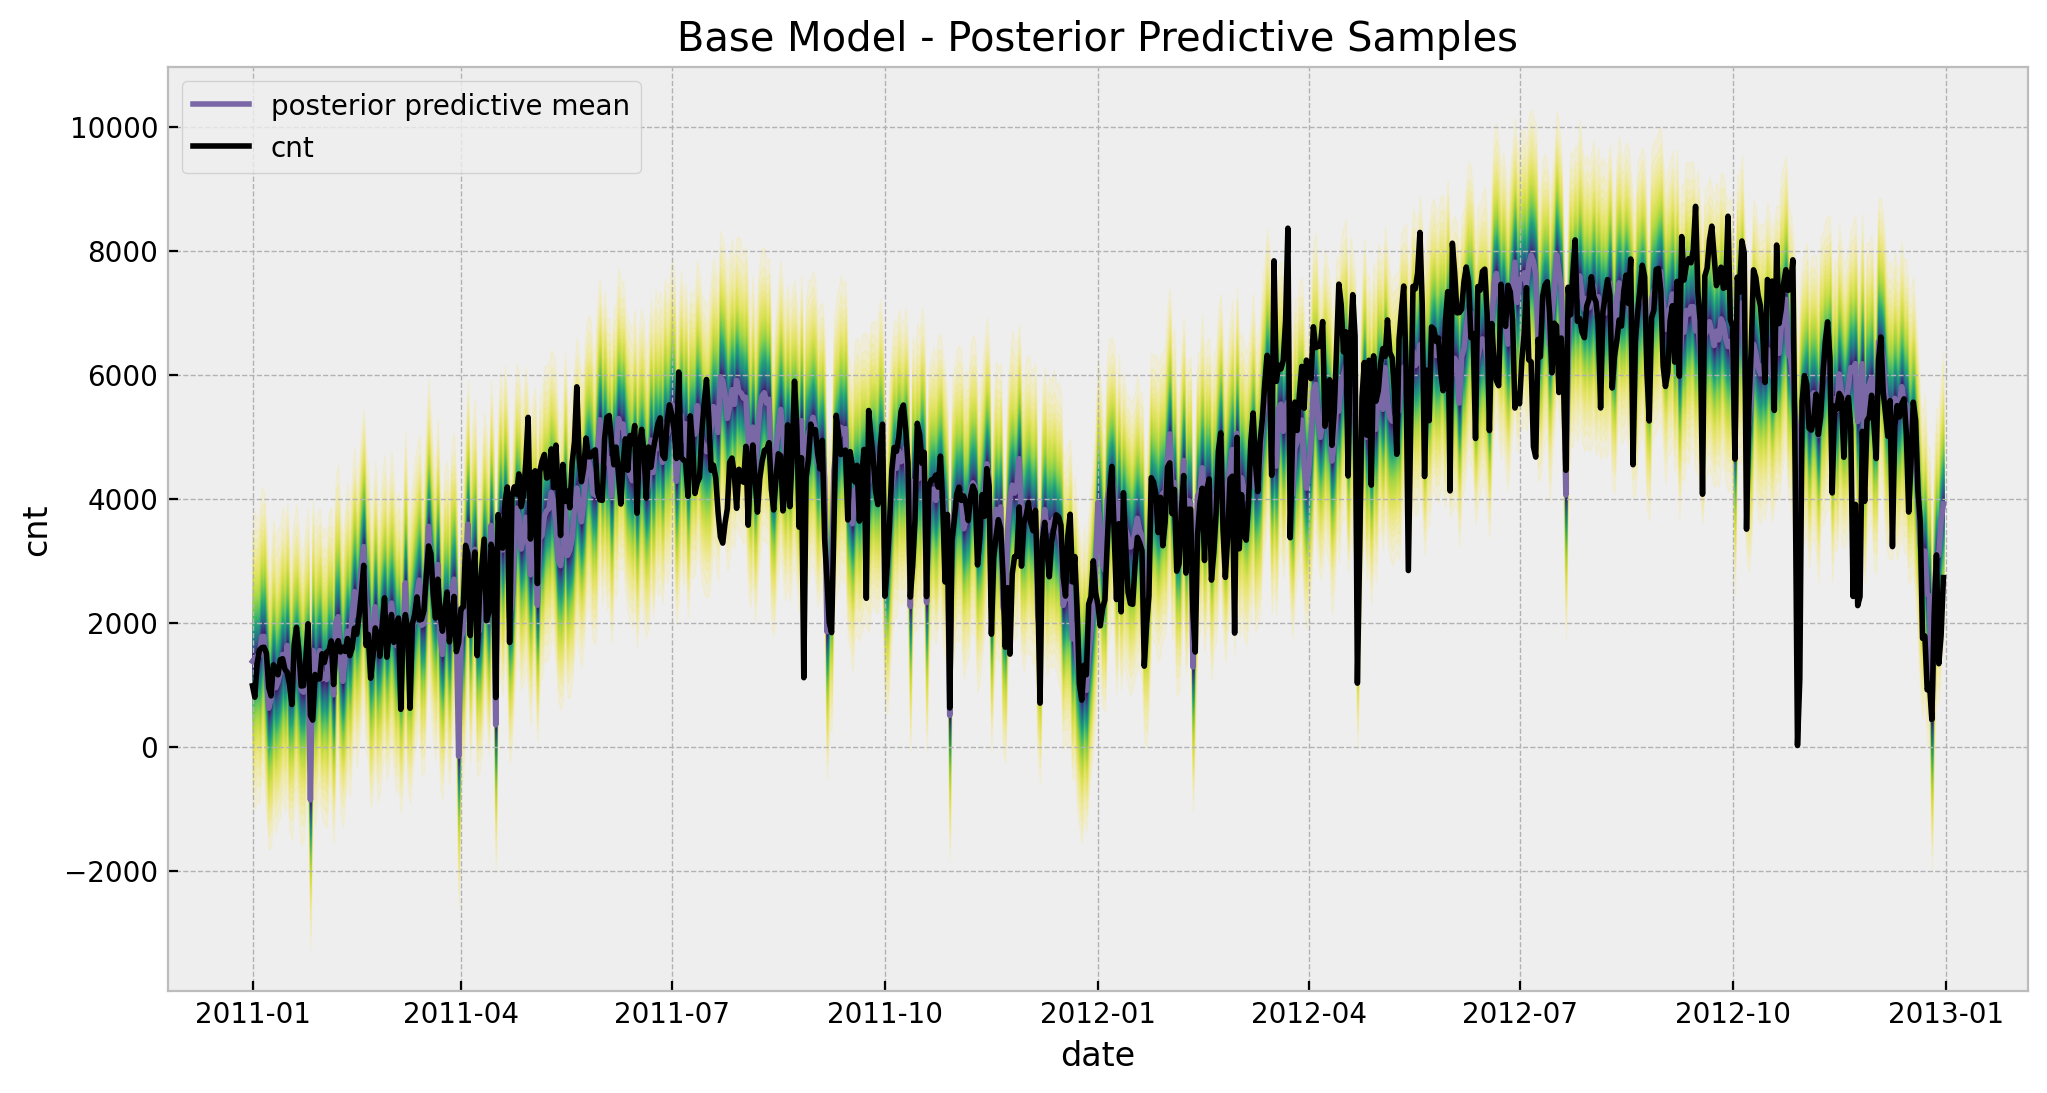

In [25]:
# 5 Posterior Predictive Distribution 

palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive_base.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood.to_numpy()
)

fig, ax = plt.subplots(figsize=(12, 6))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=cnt,
    color="black",
    label=target,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Base Model - Posterior Predictive Samples",
    xlabel="date",
    ylabel=target,
)